# Energy Point Selection

This notebook demonstrates how to seleect energy points that most identify Reference spectra.

In [2]:
import selector
from selector import energy_point_selector

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import *

import utils
from importlib import reload

# to reload utils, run:
utils = reload(utils)
from utils import *

# Load Reference Data
Read in example XANES spectra in `Data` folder.

In [4]:
# df = parse_file('Data/As_exp_standards_normalized.dat')
df = parse_file('Data/As_edge_sim_standards_phases_normalized.dat')
df.head()

,X1,As(10A) mp11,X2,CdAs mp7373,X3,TeAs mp10051,X4,CdAs2 mp471,X5,Te3As2 mp484 merged
0,11856.61600,0.003277854,11856.61600,0.002723912,11856.61600,0.001111969,11856.61600,0.000899178,11856.61600,0.000565130
1,11858.33300,-0.003323150,11858.33300,-0.002773540,11858.33300,-0.002329604,11858.33300,-0.001883802,11858.33300,-0.001183961
2,11859.90100,-0.003870878,11859.90100,-0.003191487,11859.90100,0.001217634,11859.90100,0.000984623,11859.90100,0.000618831
3,11861.32000,0.003916174,11861.32000,0.003241114,11861.32000,0.014743182,11861.32000,0.011678859,11861.32000,0.007160494
4,11862.59000,0.023870548,11862.59000,0.019445168,11862.59000,0.043491259,11862.59000,0.033859074,11862.59000,0.020377544


In [5]:
# Energy = np.array(df['energy'], dtype=float)
# Refs = np.array(df.iloc[:, 1:], dtype=float).T
Energy = np.array(df['X1'], dtype=float)
data_columns = [colm for colm in df.columns if len(colm.replace('X', '')) != 1]
Refs = np.array(df[data_columns], dtype=float).T

Visualize reference spectra

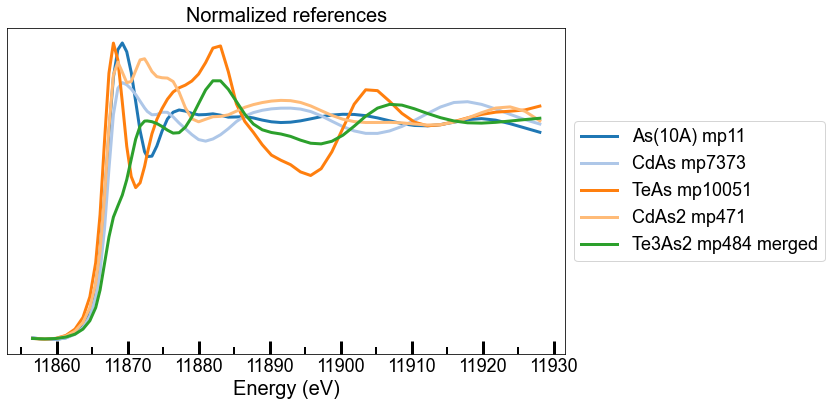

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    energy = np.array(df[f'X{i + 1}'], dtype=float)
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(i), label=data_columns[i])
ax.legend(fontsize=18, loc='center left', bbox_to_anchor=(1., .5))
plt.title("Normalized references", fontsize=20)
format_axis(ax)
plt.show()

# PCA Analysis

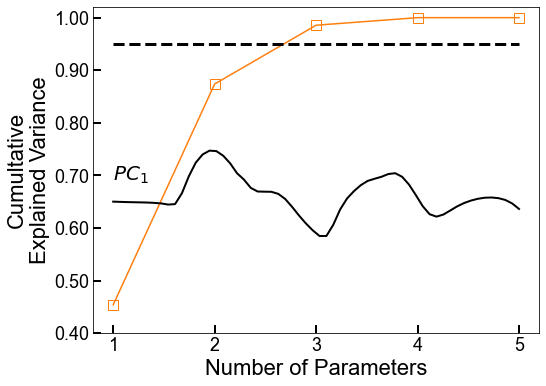

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

pca = PCA()
pca_components = pca.fit_transform(Refs)

n = 5
x = np.arange(n) + 1
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
        color=plt.cm.tab10(.15))
ax.plot(x, np.ones(len(x)) * 0.95, 'k--', linewidth=3)

PC1 = pca.components_[0]
plt.plot(np.linspace(1, 5, len(PC1)), -PC1*0.3 + 0.65, 'k', linewidth=2)
text = ax.text(1, 0.7, '$PC_1$', ha="left", va="center", size=20)

plt.xticks(x, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0.4, 1.02)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)
plt.show()

# Generate dataset

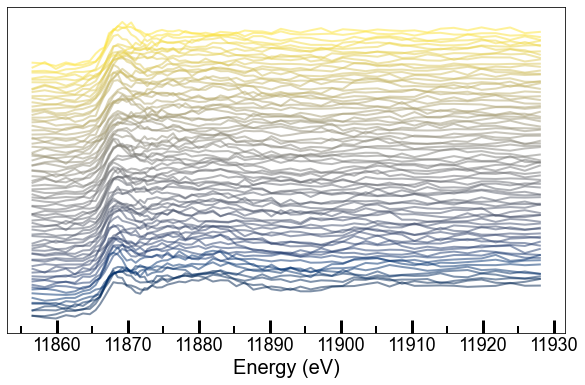

In [8]:
N = 800
scale = 0.05
dropout = 0.5

data, coeffs = generate_linear_combos(Refs, N=N, scale=scale, dropout=dropout)
test_data, test_coeffs = generate_linear_combos(Refs, scale=scale, N=50, dropout=dropout)

fig, ax = plt.subplots(figsize=(10, 6))
for i, spectrum in enumerate(data):
    if not i%10:
        ax.plot(Energy, spectrum + i*0.01, '-', linewidth=2, c=plt.cm.cividis(i/N), alpha=0.5)
format_axis(ax)
plt.show()

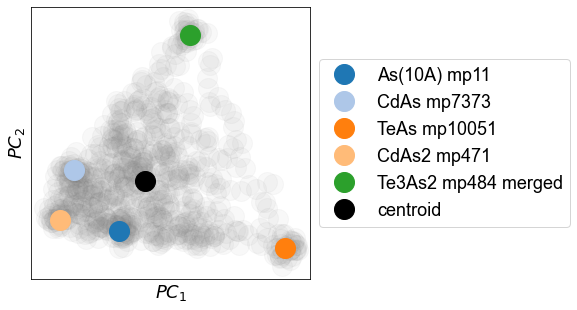

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_pca = True
if plot_pca:
    pca = PCA(n_components=2)
    pca = pca.fit(data)
else:
    tsne = TSNE(n_components=2)
    total_data = np.array([x for y in [data, Refs] for x in y])
    transformed_data = tsne.fit_transform(total_data)

if plot_pca:
    transformed = pca.transform(data)
else:
    transformed = transformed_data[:-len(Refs)]

for i, coords in enumerate(transformed):
    ax.plot(coords[0], coords[1], 'o', markersize=20, c='gray', alpha=0.05)

if plot_pca:
    transformed_Refs = pca.transform(Refs)
else:
    transformed_Refs = transformed = transformed_data[-len(Refs):]

for i, coords in enumerate(transformed_Refs):
    ax.plot(coords[0], coords[1], 'o', markersize=20, c=plt.cm.tab20(i), label=data_columns[i])
ax.plot(np.average(transformed_Refs[:,0]), np.average(transformed_Refs[:,1]), 'o', markersize=20,
        c='k', label='centroid')

ax.legend(fontsize=18, loc='center left', bbox_to_anchor=(1., .5))
ax.set_yticks([])
ax.set_xticks([])
if plot_pca:
    ax.set_xlabel('$PC_1$', fontsize=18)
    ax.set_ylabel('$PC_2$', fontsize=18)
else:
    ax.set_xlabel('$X_1$', fontsize=18)
    ax.set_ylabel('$X_2$', fontsize=18)
plt.show()

# Initialize Selector and perform selection algorithm

### Some potential advancements:

1. Logistic regression and xgboost are models with feature importances that will work if the labels were one dimensional. A work around is using a RegressorChain or MultiOutputRegressor wrapper model.

2. Gaussian processes and other nonlinear models would work if permutation_importance worked as the importance_getter

e.g.

` def importance(model):`
    
 &emsp; &emsp; ` return permutation_importance(model, data, coeffs, scoring='neg_mean_squared_error')`
    
` importance_getter = importance`

These features can theoretically be implemented to improve the RFE algorithm.

In [24]:
energy_point_selector = reload(selector.energy_point_selector)
select = energy_point_selector.Selector(data, coeffs)

For a list of possible scoring criteria, see `sklearn.metrics.SCORERS.keys()`

In [10]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
n_points = [6, 8, 10, 12]
Scores = []
Epts = []

for npts in n_points:
    print(f'\nNum points: {npts}\n-----------------------')
    scores = []
    epts = []
    for model in models:
        print(f'\n{model}:')
        select = energy_point_selector.Selector(data, coeffs)
        rfe, cvscore = select.select_energy_points(estimator=model, n_points=npts,
                                                 scoring='neg_root_mean_squared_error')
        energy_points = Energy[rfe.support_]
        epts.append(energy_points)
        scores.append(cvscore)
    Scores.append(scores)
    Epts.append(epts)


Num points: 4
-----------------------

Linear Regression:
Score: -0.085 (0.004)

Decision Tree:
Score: -0.160 (0.009)

Random Forest:
Score: -0.093 (0.004)

Num points: 6
-----------------------

Linear Regression:
Score: -0.085 (0.004)

Decision Tree:
Score: -0.161 (0.008)

Random Forest:
Score: -0.094 (0.004)

Num points: 8
-----------------------

Linear Regression:
Score: -0.085 (0.004)

Decision Tree:
Score: -0.161 (0.009)

Random Forest:
Score: -0.094 (0.004)

Num points: 10
-----------------------

Linear Regression:
Score: -0.085 (0.004)

Decision Tree:
Score: -0.161 (0.008)

Random Forest:
Score: -0.094 (0.004)


# Visualize Selected Energy Points

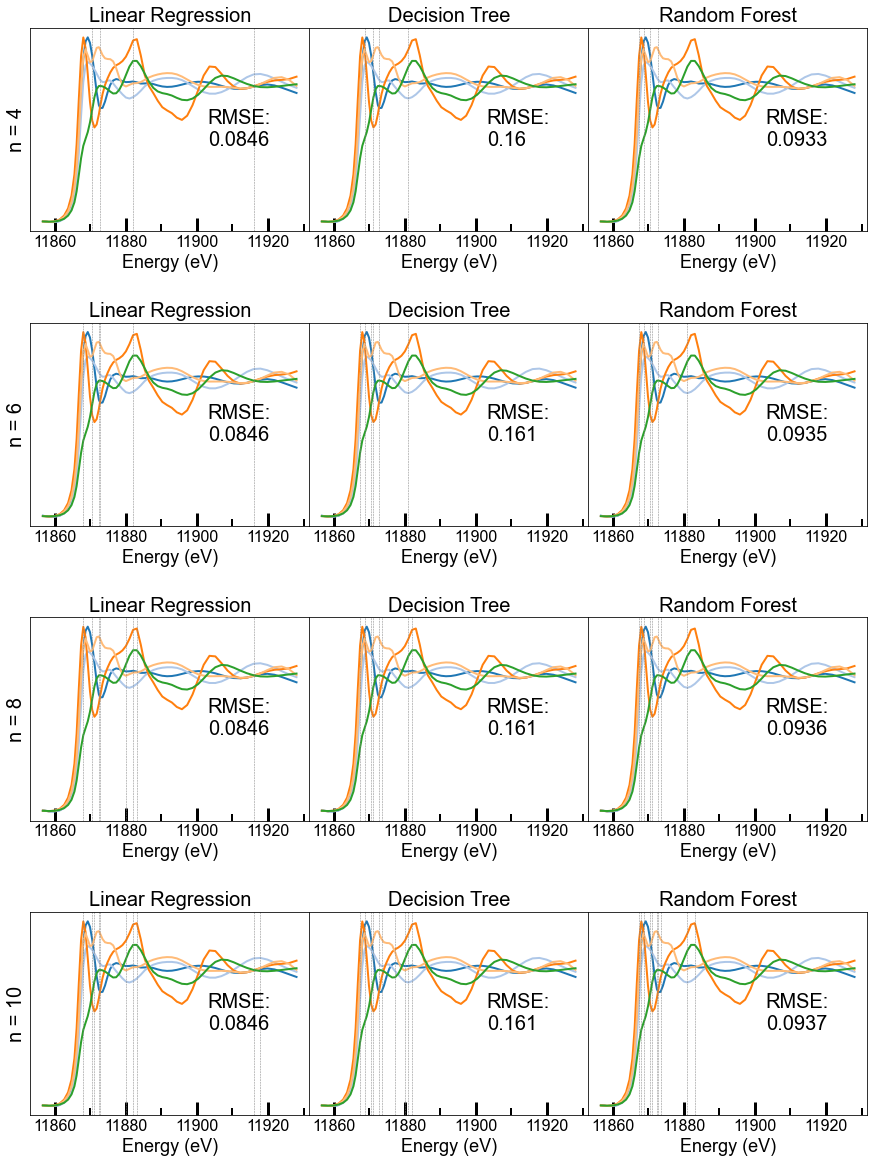

In [13]:
nrows = len(n_points)
ncols = len(models)
fig, axes = plt.subplots(figsize=(ncols*5, nrows*5), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0, hspace=0.45)

for i, npts in enumerate(n_points):
    row_axes = axes[i]
    for energy_pts, model, score, ax in zip(Epts[i], models, Scores[i], row_axes):
        diff = 25
        ticks = (10, 20)
        visualize_energy_points((fig, ax), Energy, Refs,
                                energy_pts, ticks=ticks, label=model)
        text = ax.text(np.max(Energy) - diff, np.max(Refs)*0.5, f'RMSE:\n{-score:.3}',
                       ha="left", va="center", size=20)
    label = row_axes[0].set_ylabel(f'n = {npts}', fontsize=20)

# Model Selection

The best model is the linear regression with n = 6 energy points.
We will use the energy points indicating by that model.

In [44]:
best_estimator = 'Linear Regression'
best_n = 8
rfe, cvscore = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                           scoring='neg_root_mean_squared_error')
energy_measurements = Energy[rfe.support_]
# energy_measurements = Epts[1][0]
indices = [i for i, e in enumerate(Energy) if e in energy_measurements]

Score: -0.085 (0.004)


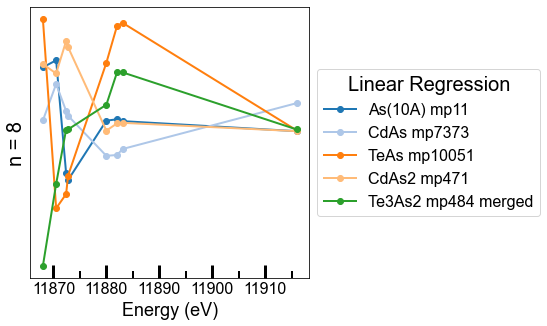

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

diff = 11.8
diff = -2
ticks = (5, 10)
fontsize=20

for i, ref in enumerate(Refs[:, indices]):
    ax.plot(Energy[indices], ref, 'o-', linewidth=2, c=plt.cm.tab20(i),
            label=data_columns[i])
format_axis(ax, ticks=ticks, fontsize=fontsize-2)
ax.legend(fontsize=fontsize-4, loc='center left', bbox_to_anchor=(1., .5),
         title=f'{best_estimator}', title_fontsize=fontsize)
label = ax.set_ylabel(f'n = {best_n}', fontsize=20)

## Validate Regression Task using energy subset

Train and score each regression model using the selected energy subset to predict the linear combination coefficients.

In [46]:
ref_coeff = np.identity(Refs.shape[0])
m, x, y, z = 'Model', 'Train', 'Validation', 'Refs'
print(f'{m:45s}| {x:20s}| {y:20s}| {z:20s} ')
print('-'*105)
    
for reg in [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(),
            GaussianProcessRegressor(), MLPRegressor(hidden_layer_sizes=(40, 40)),
            Lasso()]:
    
    reg.fit(data[:, indices], coeffs)
    
    x = f'{reg.score(data[:, indices], coeffs):.4f}'
    y = f'{reg.score(test_data[:, indices], test_coeffs):.4f}'
    z = f'{reg.score(Refs[:, indices], ref_coeff):.4f}'
    print(f'{str(reg):45s}| {x:20s}| {y:20s}| {z:20s} ')

Model                                        | Train               | Validation          | Refs                 
---------------------------------------------------------------------------------------------------------
LinearRegression()                           | 0.7805              | 0.7835              | 0.8970               
RandomForestRegressor()                      | 0.9789              | 0.8241              | 0.9992               
DecisionTreeRegressor()                      | 1.0000              | 0.4754              | 1.0000               
GaussianProcessRegressor()                   | 0.9951              | -9.1992             | 0.8510               
MLPRegressor(hidden_layer_sizes=(40, 40))    | 0.7448              | 0.7389              | 0.8351               
Lasso()                                      | -0.0000             | -0.0241             | -0.0003              


` The Random Forest Regressor performed the best and subsequent analysis should use this model.`

## Test dataset
Test on experimental data.

In [47]:
reg = RandomForestRegressor()
reg.fit(data[:, indices], coeffs)

y_pred = reg.predict(test_data[:, indices])
print(f'Add to one? {np.sum(y_pred, axis=1).all()}')

for metric in ["mean_squared_error", "explained_variance_score"]:
    test_score = eval(metric)(y_pred, test_coeffs)
    metric = metric.replace('_', ' ')
    print(f'{metric}: {test_score:.5f}')

Add to one? True
mean squared error: 0.01044
explained variance score: 0.71322


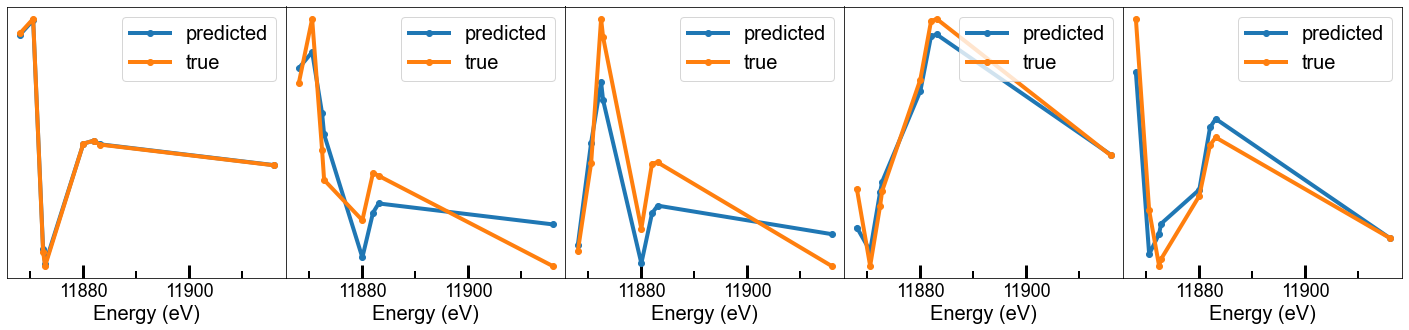

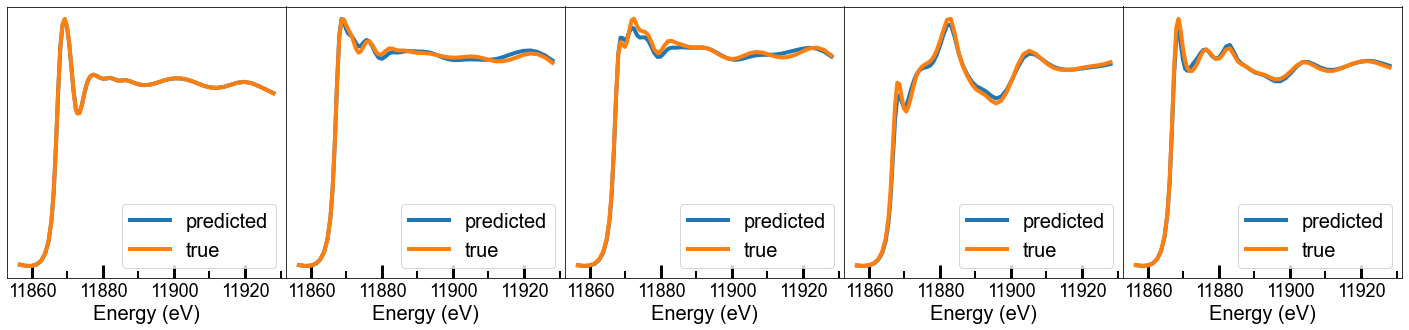

In [48]:
for show_subset in [True, False]:
    
    m = 5
    fig, axes = plt.subplots(figsize=(5*m, 5), ncols=m)
    plt.subplots_adjust(wspace=0)

    for i in range(m):
        pred = Refs.T @ y_pred[i]
        true = Refs.T @ test_coeffs[i]
        ax = axes[i]

        if show_subset:
            ax.plot(Energy[indices], pred[indices], 'o-', linewidth=4, c=plt.cm.tab20(0), label='predicted')
            ax.plot(Energy[indices], true[indices], 'o-', linewidth=4, c=plt.cm.tab20(2), label='true')
            loc = 1
            ticks=(1, 4)
            ticks=(10,20)
        else:
            ax.plot(Energy, pred, '-', linewidth=4, c=plt.cm.tab20(0), label='predicted')
            ax.plot(Energy, true, '-', linewidth=4, c=plt.cm.tab20(2), label='true')
            loc = 4
            ticks=(10, 20)

        format_axis(ax, ticks=ticks, fontsize=20)
        ax.legend(fontsize=20, loc=loc)
    plt.show()